In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavansekharnaidu","key":"7cf8536826e0185d0db19e5307538f18"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           2409         31  1.0              
waqi786/cats-dataset                                       🐾 Cats Dataset                                       6KB  2024-07-31 06:12:49           2147         44  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020      Olympic Historical Dataset (1896 - 2022)            27MB  2024-08-06 16:46:08           1284         28  1.0              
patricklford/global-ev-sales-2010-2024                     Global EV Sales: 2010-2024     

In [5]:
!kaggle datasets download -d marcozuppelli/stegoimagesdataset

Dataset URL: https://www.kaggle.com/datasets/marcozuppelli/stegoimagesdataset
License(s): DbCL-1.0
100% 1.51G/1.51G [01:29<00:00, 20.9MB/s]
100% 1.51G/1.51G [01:29<00:00, 18.1MB/s]


In [6]:
!unzip stegoimagesdataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/val/stego/image_06334_ps_0.png  
  inflating: val/val/stego/image_06334_ps_1.png  
  inflating: val/val/stego/image_06335_eth_0.png  
  inflating: val/val/stego/image_06335_html_0.png  
  inflating: val/val/stego/image_06335_url_0.png  
  inflating: val/val/stego/image_06336_html_0.png  
  inflating: val/val/stego/image_06336_html_1.png  
  inflating: val/val/stego/image_06336_url_0.png  
  inflating: val/val/stego/image_06337_html_0.png  
  inflating: val/val/stego/image_06337_js_0.png  
  inflating: val/val/stego/image_06337_url_0.png  
  inflating: val/val/stego/image_06338_eth_0.png  
  inflating: val/val/stego/image_06338_js_0.png  
  inflating: val/val/stego/image_06338_url_0.png  
  inflating: val/val/stego/image_06339_eth_0.png  
  inflating: val/val/stego/image_06339_html_0.png  
  inflating: val/val/stego/image_06339_js_0.png  
  inflating: val/val/stego/image_06340_html_0.png  
  inflating: val/val/stego/ima

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Dropout,Rescaling, Resizing, Reshape
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1

In [8]:
train_directory = '/content/train/train'
test_directory = '/content/test/test'
val_directory = '/content/val/val'

CLASS_NAMES = 'stego','clean'


In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 16000 files belonging to 2 classes.


In [10]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 8000 files belonging to 2 classes.


In [11]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 8000 files belonging to 2 classes.


1
0
1
0
1
0
0
0
0
1
0
1
0
1
0
1


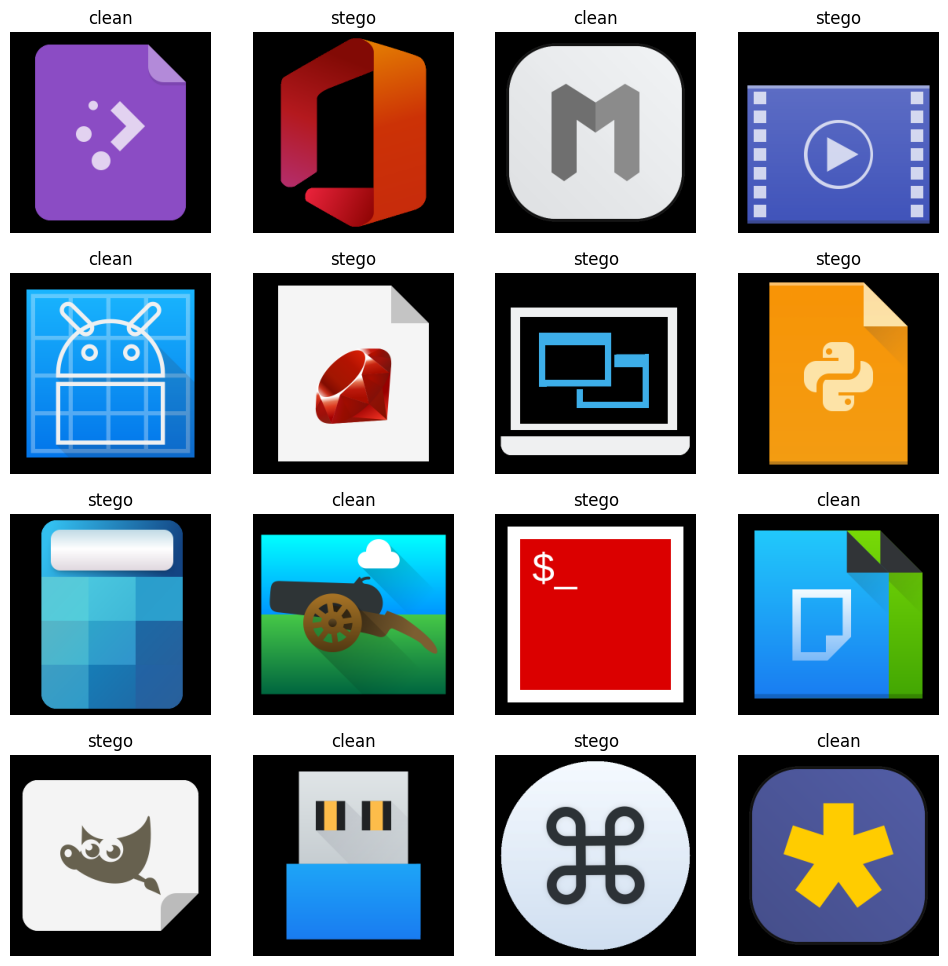

In [12]:
plt.figure (figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    print(labels[i].numpy().argmax())
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[labels[i].numpy().argmax()])
    plt.axis('off')

In [13]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def res_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    if conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, (kernel_size, kernel_size), padding='same', strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_custom_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    for _ in range(3):
        x = res_block(x, 64)

    x = res_block(x, 128, stride=2, conv_shortcut=True)
    for _ in range(3):
        x = res_block(x, 128)

    x = res_block(x, 256, stride=2, conv_shortcut=True)
    for _ in range(5):
        x = res_block(x, 256)


    x = res_block(x, 512, stride=2, conv_shortcut=True)
    for _ in range(2):
        x = res_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 3)
num_classes = 2


model = build_custom_resnet(input_shape, num_classes)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,665,154 (86.46 MB)

 Trainable params: 22,642,370 (86.37 MB)

 Non-trainable params: 22,784 (89.00 KB)

Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 219s 319ms/step - accuracy: 0.7373 - loss: 0.6467 - val_accuracy: 0.7500 - val_loss: 0.5687
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 318ms/step - accuracy: 0.7519 - loss: 0.5652 - val_accuracy: 0.7500 - val_loss: 0.5766


In [15]:
prediction = model.predict(test_dataset)


250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


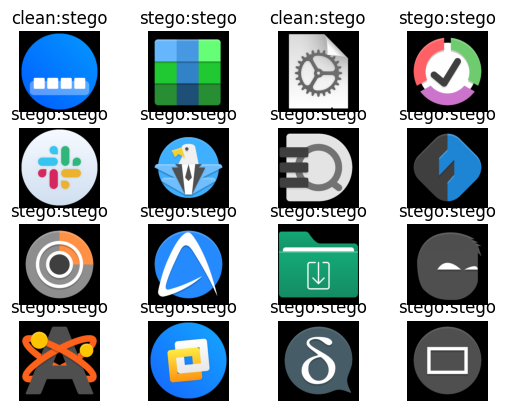

In [16]:
for image,labels in test_dataset.take(1):
    predicted = model.predict(image)

    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.0)
        plt.title(str(CLASS_NAMES[tf.argmax(labels[i])]) + ':'+ str(CLASS_NAMES[tf.argmax(predicted[i])]))
        plt.axis('off')


plt.show()